<a href="https://colab.research.google.com/github/benai9916/Data_science_tasks/blob/main/tegger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

 Please show the number of articles 

1.   How many articles are about G20 countries?  **1444**
2.   The number of articles for each individual country: **2545**
3.   Articles of those countries that have an overlap in talking about several countries: **1337**

In [1]:
import gdown
import re
import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import models
from gensim import corpora
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# set the colum width to display 
pd.set_option('display.max_colwidth', 100)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Download data

url = 'https://drive.google.com/uc?id=1GiUopdHpSD5AyQhP3ij-xk9EENehK3mt'
output = 'bcc_fulltext.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1GiUopdHpSD5AyQhP3ij-xk9EENehK3mt
To: /content/bcc_fulltext.zip
2.87MB [00:00, 38.4MB/s]


'bcc_fulltext.zip'

In [3]:
# unzip the data

!unzip bcc_fulltext.zip

Archive:  bcc_fulltext.zip
replace bbc/business/001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: bbc/business/001.txt    
  inflating: bbc/business/002.txt    
  inflating: bbc/business/003.txt    
  inflating: bbc/business/004.txt    
  inflating: bbc/business/005.txt    
  inflating: bbc/business/006.txt    
  inflating: bbc/business/007.txt    
  inflating: bbc/business/008.txt    
  inflating: bbc/business/009.txt    
  inflating: bbc/business/010.txt    
  inflating: bbc/business/011.txt    
  inflating: bbc/business/012.txt    
  inflating: bbc/business/013.txt    
  inflating: bbc/business/014.txt    
  inflating: bbc/business/015.txt    
  inflating: bbc/business/016.txt    
  inflating: bbc/business/017.txt    
  inflating: bbc/business/018.txt    
  inflating: bbc/business/019.txt    
  inflating: bbc/business/020.txt    
  inflating: bbc/business/021.txt    
  inflating: bbc/business/022.txt    
  inflating: bbc/business/023.txt    
  inflating: bbc/business/024

In [4]:
# load data from all different categories into a dataframe

def create_df(i):
    df = pd.DataFrame()
    for file in os.listdir(i):
        if file != '.ipynb_checkpoints':
            try:
                text = pd.read_csv(i+'/'+file, sep='\n', header=None, error_bad_lines=False, encoding='latin')[0].str.cat()
                df = df.append(pd.Series(text), ignore_index=True)
                df['category'] = file
            except Exception as e:
                print(e)
    
    # add a category column to identify the articel category
    df['category'] = i.split('/')[1]
    return df

In [5]:
%%time
business =  create_df('bbc/business')
ent =  create_df('bbc/entertainment')
politics =  create_df('bbc/politics')
sport =  create_df('bbc/sport')
tech =  create_df('bbc/tech')

b'Skipping line 11: expected 1 fields, saw 2\n'
b'Skipping line 7: expected 1 fields, saw 2\n'


Error tokenizing data. C error: EOF inside string starting at row 8


b'Skipping line 3: expected 1 fields, saw 2\n'
b'Skipping line 19: expected 1 fields, saw 2\n'
b'Skipping line 7: expected 1 fields, saw 2\n'


CPU times: user 10 s, sys: 51.4 ms, total: 10.1 s
Wall time: 10.1 s


b'Skipping line 7: expected 1 fields, saw 2\n'
b'Skipping line 7: expected 1 fields, saw 2\n'


In [6]:
# size of each dataframe

business.shape, ent.shape, politics.shape, sport.shape, tech.shape

((510, 2), (386, 2), (417, 2), (510, 2), (401, 2))

In [7]:
# join all the dataframe into on final dataframe

final_df = pd.concat([business, ent, politics, sport, tech])

In [8]:
# renaming the column

final_df = final_df.rename(columns={0:'text'})
final_df.head()

,text,category
0,Japan economy slides to recessionThe Japanese economy has officially gone back into recession fo...,business
1,Firms pump billions into pensionsEmployers have spent billions of pounds propping up their final...,business
2,Irish company hit by Iraqi reportShares in Irish oil company Petrel Resources have lost more tha...,business
3,"WorldCom bosses' $54m payoutTen former directors at WorldCom have agreed to pay $54m (Â£28.85m),...",business
4,Ad firm WPP's profits surge 15%UK advertising giant WPP has posted larger-than-expected annual p...,business


In [9]:
# List of all G20 Countries.
# Few countries have multiple names Example united state is also known as US, or USA so i have added the same in the below list

g20 = [ 'Argentina', 'Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India', 'Indonesia', 'Italy', 'Japan', 'Republic of Korea', 'South korea', 'Mexico', 'Russia', 'Saudi Arabia', 'South Africa', 'Turkey', 'United Kingdom', 'UK', 'United States', 'US', 'USA','European Union', 'EU'] 

## Text pre-processing

In [10]:
# clean data

# have done lemmatizing to remove inflectional from the sentence and to get the root form of the word
lemmatizer = WordNetLemmatizer()
def clean_data(text, model=False):
    # Make all the strings lowercase and remove non-alphabetic characters
    text = re.sub('[^A-Za-z]+', ' ', text)
    
    # Tokenize the text; this is, separate every sentence into a list of words
    tokenized_text = nltk.word_tokenize(text)
    
    # Remove the stopwords and lemmatize each word to its root so that it will help us to process the text fast
    lem_tokens = [lemmatizer.lemmatize(token) for token in tokenized_text if token not in stopwords.words('english')]
    
    # will required token to ued in LDA model for topic modeling
    if model == True:
        return lem_tokens
    else:
        #Return a string to ge the total no of articles, and articel for each individual countries
        return ' '.join(lem_tokens)

## Select topic in each article

In [11]:
'''
LDA represnt document as as mixtre of topic and split out words into certain posibilities 
Gensim Used optimized latent dirichlet allocation model for topic selection
''' 

def topics_model(article):
    article_topic = []

    texts = clean_data(article, model=True)

    texts = [clean_data(text, model=True) for text in texts]
    
    # mapp between words and their integer ids.
    dictionary = corpora.Dictionary(texts)
    
    # convert document to a bag-of-word format i.e two tuple containing token-id and token-count
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    '''parameters (corpus -> Stream of document vectors or sparse matrix of shape)
       num_topics -> number of topics to be extracted from the training corpus
       id2word  -> Mapping word id to word
       passes -> number of passes through corpus training
    '''
    model = models.ldamodel.LdaModel(corpus, num_topics=1, id2word=dictionary, passes=15)

    # get the most ranked topic from the corpus
    topics = model.print_topics(num_words=3)
    for topic in topics:
        article_topic.append(re.sub('[^A-Za-z]+', ' ',topic[1]))
            
    return article_topic

## Exploring article

In [12]:
def g20_countries(articles):
    
    no_of_article = 0
    countries = set()
    article = set()
    multi_country_topic = list()
    
    individual_country = pd.DataFrame([])
    multi_country = pd.DataFrame([])

    country_str = ''

    for country in countries:
      country_str.join(country)
    
    # Count the number of G20 countries  in each  article only once
    words_re = re.compile("|".join(g20))
    for county_article in articles.iterrows():
        sent = clean_data(county_article[1][0])
        if words_re.search(sent):
            no_of_article += 1
        

        for g20_country in g20:
            if g20_country in county_article[1][0]:
              # just to make sure not to save  muliple name for the same country
                if g20_country == 'USA' or g20_country == 'US':
                    g20_country = 'United States'
                elif g20_country == 'Republic of Korea':
                    g20_country = 'South korea'
                elif g20_country == 'UK':
                    g20_country = 'United Kingdom'
                elif g20_country == 'EU':
                    g20_country =  'European Union'
                    
                '''
                Create a dataframe to Show the number of articles for each individual countries, along with topics in each articles and category
                '''
                individual_country_topic = topics_model(county_article[1][0])
                individual_country = individual_country.append(pd.DataFrame({'text': county_article[1][0], 'country': g20_country, 'topic': " ".join(individual_country_topic) ,'category': county_article[1]['category']}, index=[0]), ignore_index=True, sort=False)

                '''
                Create a dataframe to show the articele for overlaping countries, with topics in each articles and categories
                '''
                countries.add(g20_country)
                article =  county_article[1][0]
                
                multi_country_topic = topics_model(county_article[1][0])
                multi_country = multi_country.append(pd.DataFrame({'text': article, 'country': " ".join(countries), 'topic': multi_country_topic[0],'category': county_article[1]['category']}, index=[0]), ignore_index=True, sort=False)

                
    return no_of_article, individual_country, multi_country
        

In [13]:
no_of_country, individual_country, multi_country = g20_countries(final_df)

In [14]:
# Total no of articles about G20 Countries

print('Total no of articles about G20 Countries: ', no_of_country)

Total no of articles about G20 Countries:  1444


In [15]:
# No of articles for each individual countries with the topic 

individual_country.head()

,text,country,topic,category
0,Japan economy slides to recessionThe Japanese economy has officially gone back into recession fo...,Japan,economy growth The,business
1,Irish company hit by Iraqi reportShares in Irish oil company Petrel Resources have lost more tha...,Turkey,Iraq company contract,business
2,"WorldCom bosses' $54m payoutTen former directors at WorldCom have agreed to pay $54m (Â£28.85m),...",France,director said former,business
3,"WorldCom bosses' $54m payoutTen former directors at WorldCom have agreed to pay $54m (Â£28.85m),...",United States,director said former,business
4,Ad firm WPP's profits surge 15%UK advertising giant WPP has posted larger-than-expected annual p...,United Kingdom,WPP profit firm,business


In [16]:
individual_country['country'].value_counts()

United States     746
United Kingdom    548
France            189
Australia         146
European Union    122
Japan             120
Russia             98
India              93
Germany            92
China              92
Italy              83
South Africa       59
Brazil             35
Canada             34
Argentina          24
Indonesia          22
Mexico             18
Turkey             15
Saudi Arabia        9
Name: country, dtype: int64

In [17]:
# number of article for individual countries
print('The number of articles for each individual country: ', individual_country.shape[0])

The number of articles for each individual country:  2545


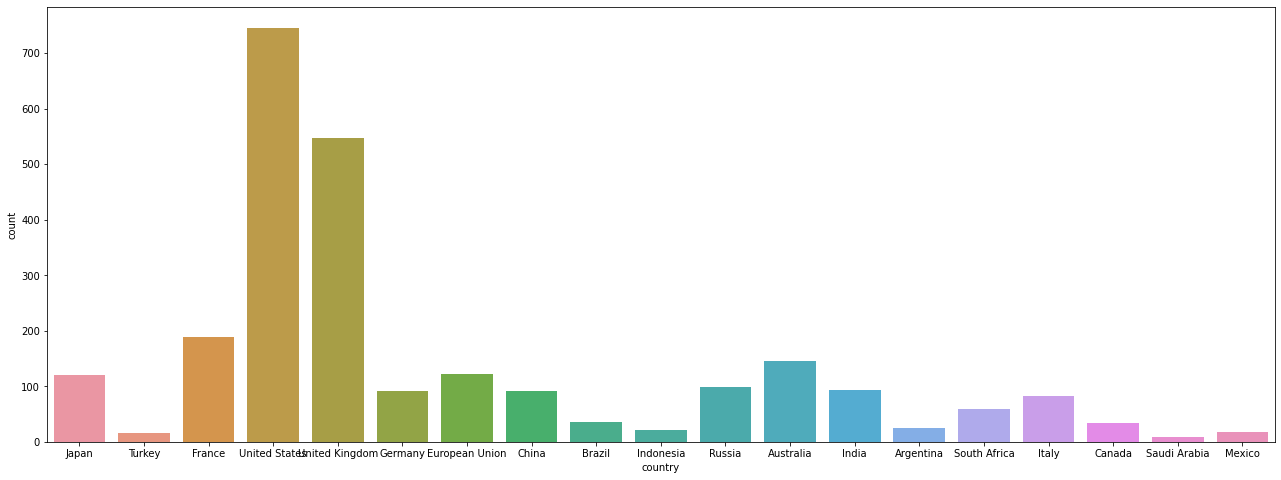

In [18]:
plt.figure(figsize=(22, 8))
sns.countplot(x ='country', data =individual_country)
plt.show()

##### From the above grapah we can see that more article are about US, UK

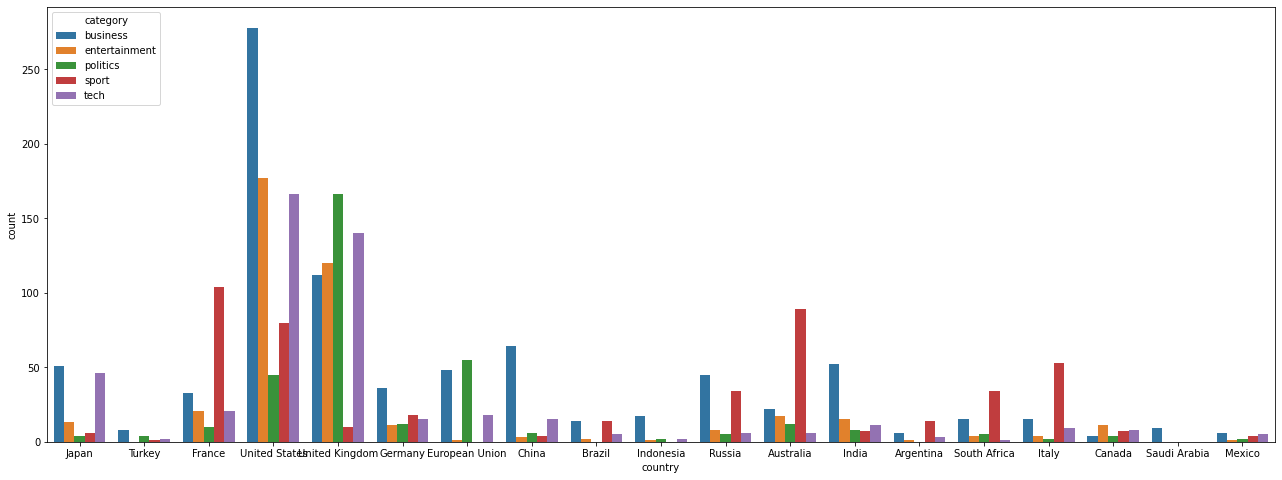

In [19]:
plt.figure(figsize=(22, 8))
sns.countplot(x='country', data=individual_country, hue='category')

From the above graph we can see that the most common category are business, sports

In [20]:
# remove duplicate rows

multi_country.drop_duplicates(subset ="text", keep = 'last', inplace = True) 
multi_country.head()

,text,country,topic,category
0,Japan economy slides to recessionThe Japanese economy has officially gone back into recession fo...,Japan,economy growth The,business
1,Irish company hit by Iraqi reportShares in Irish oil company Petrel Resources have lost more tha...,Turkey Japan,Iraq company contract,business
3,"WorldCom bosses' $54m payoutTen former directors at WorldCom have agreed to pay $54m (Â£28.85m),...",France United States Turkey Japan,director said former,business
5,Ad firm WPP's profits surge 15%UK advertising giant WPP has posted larger-than-expected annual p...,France United States Turkey United Kingdom Japan,WPP profit firm,business
6,Euronext 'poised to make LSE bid'Pan-European group Euronext is poised to launch a bid for the L...,France United States Turkey United Kingdom Japan,LSE Euronext exchange,business


In [21]:
# number of article for overlaping countries

print('The number of articles for each overlaping country: ', multi_country.shape[0])

The number of articles for each overlaping country:  1377


In [ ]:
business_theme = ''
sports_theme = ''
politics_theme = ''
ent_theme = ''
tech_theme = ''

theme = multi_country.groupby('category')['topic']
category = multi_country['category'].unique()

for c in category:
  for words in theme.get_group(c):
    if c == 'business':
      business_theme = business_theme.join(words.strip())
    elif c == 'entertainment':
      ent_theme.join(words.strip())
    elif c == 'politics':
      politics_theme.join(words.strip())
    elif c == 'sport':
      sports_theme.join(words.strip())
    elif c == 'tech':
      tech_theme.join(words.strip())

In [ ]:
business_theme